# Comparing old v young in ACE2 expression

In [1]:
import glob
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import scanpy as sc
from scipy import stats

from collections import OrderedDict
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.preprocessing import scale

from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from matplotlib import cm
from matplotlib.lines import Line2D

def nd(arr):
    return np.asarray(arr).reshape(-1)
def yex(ax):
    lims = [np.min([ax.get_xlim(), ax.get_ylim()]),
            np.max([ax.get_xlim(), ax.get_ylim()])]

    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    return ax

def trim_axs(axs, N):
    """little helper to massage the axs list to have correct length..."""
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]

import warnings
warnings.filterwarnings('ignore')

fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

/home/sina/bin/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [2]:
age_map = {
    "SRR8426358": 24,
    "SRR8426359": 24,
    "SRR8426362": 24,
    "SRR8426363": 24,
    "SRR8426364": 24,
    "SRR8426369": 24,
    "SRR8426370": 24,
    "SRR8426360": 3,
    "SRR8426361": 3,
    "SRR8426365": 3,
    "SRR8426366": 3,
    "SRR8426367": 3,
    "SRR8426368": 3,
    "SRR8426371": 3,
    "SRR8426372": 3
}

In [3]:
data = anndata.read_h5ad("write/data.h5ad")

# ACE2 expression

In [65]:
gene = "Ace2"

In [66]:
mask = nd(data.layers["raw"].todense()[:,data.var.index.values==gene])>0
print("There {} cells with non-zero expression of {}.".format(mask.sum(), gene))

There 180 cells with non-zero expression of Ace2.


In [67]:
young_mask = data.obs.age==3
old_mask = data.obs.age==24

In [68]:
print("There {} 3 month lung cells with non-zero expression of {}.".format(np.logical_and(mask, young_mask).sum(), gene))
print("There {} 24 month lung cells with non-zero expression of {}.".format(np.logical_and(mask, old_mask).sum(), gene))

There 130 3 month lung cells with non-zero expression of Ace2.
There 50 24 month lung cells with non-zero expression of Ace2.


## Per condition and per replicate

In [69]:
assignments = data.obs.leiden.values.astype(int)
unique = np.unique(assignments)
mtx = data.layers["raw"]

In [70]:
gene_idx = np.where(data.var.index.values==gene)[0][0]
arr = nd(mtx[:,gene_idx].todense())

df = data.obs.copy()

df["ACE2"] = arr

In [71]:
print((arr>0).sum())
print(data.var.index.values[gene_idx])


180
Ace2


In [72]:
df.head()

,SRR,age,cell_counts,n_genes,percent_mito,pass_count_filter,pass_mito_filter,leiden,louvain,ACE2
AAAAAAAAAAAA-SRR8426368,SRR8426368,3,11.0,11,0.000000,True,True,12,13,0.0
AAAACCGGAGGC-SRR8426368,SRR8426368,3,301.0,238,1.993356,True,True,10,11,0.0
AAAACGCACGTC-SRR8426368,SRR8426368,3,274.0,209,1.824817,True,True,3,2,0.0
AAAAGACCAAAT-SRR8426368,SRR8426368,3,648.0,339,3.549383,True,True,0,0,0.0
AAAAGGAGCAGA-SRR8426368,SRR8426368,3,471.0,312,1.273885,True,True,2,5,0.0


In [74]:
df[df["ACE2"]>0]["ACE2"].mean()

1.1888889

# Expression of ACE2

In [12]:
young = df[df["age"] == 3]["ACE2"].values.tolist()
old = df[df["age"] == 24]["ACE2"].values.tolist()
stat, p = stats.ttest_ind(young, old)
#stat, p = stats.ks_2samp(young, old)

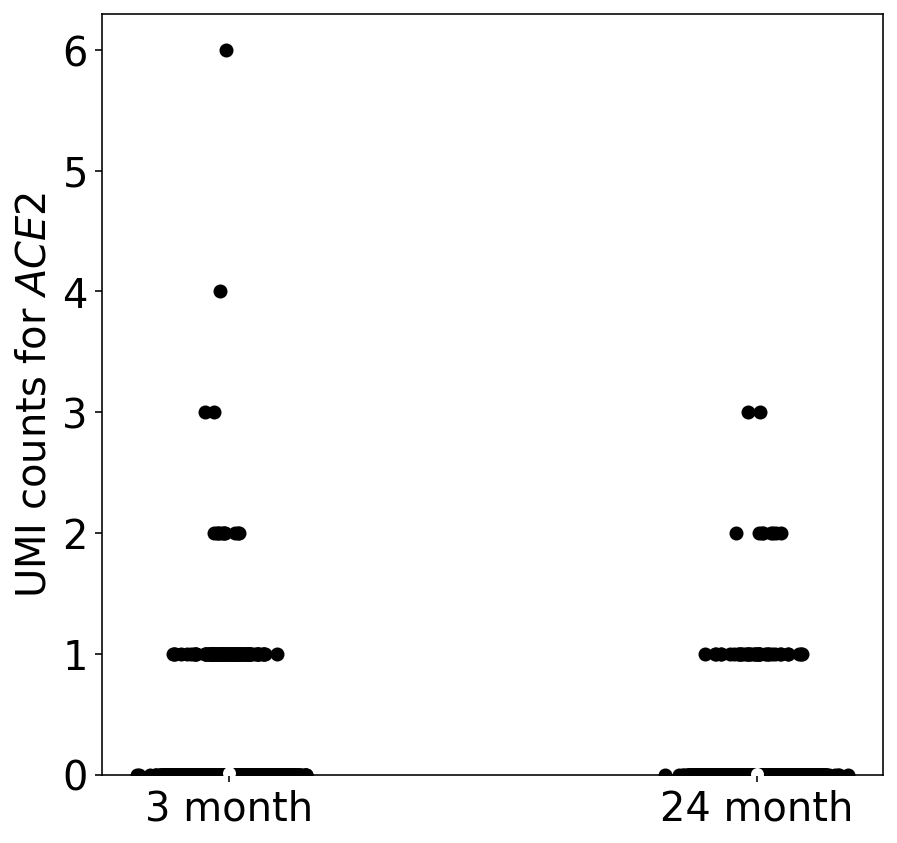

In [13]:
fig, ax = plt.subplots(figsize=(7,7))

gene = "Ace2"

labels = ['3 month', "24 month"]
lidx = [1, 2]


x = [young, old]

#parts = ax.violinplot(x, showmedians=False, showextrema=False)
#for pcidx, pc in enumerate(parts['bodies']):
#    pc.set_facecolor('#D43F3A')
#    if pcidx==1: pc.set_facecolor('#1f77b4')
#    pc.set_edgecolor('black')
#    pc.set_alpha(1)

    
mean = [np.mean(i) for i in x]
ax.scatter(lidx, mean, marker='o', color='white', s=30, zorder=3)


######## Add some random "jitter" to the x-axis
x = np.random.normal(1, 0.04, size=len(young))
ax.scatter(x, young, alpha=1, color="k")

x = np.random.normal(2, 0.04, size=len(old))
ax.scatter(x, old, alpha=1, color="k")

##########
ax.set_xticks(lidx)
ax.set_xticklabels(labels)



#ax.annotate("p={:,.3f}".format(p), (1.5, ax.get_ylim()[1]*0.02), ha="center")

ax.set_ylim(0)

ax.set_ylabel("UMI counts for $ACE2$")
#plt.savefig("./figs/old_young_ACE2_EXPRESSION.png", bbox_inches='tight',dpi=300)

plt.show()

In [14]:
print(np.mean(young))
print(np.mean(old))

0.009230021860578091
0.00492963345789934


In [15]:
p

0.0004821392090377294

# Fraction of cells expressing ACE2

In [16]:
ace2 = df.groupby(["SRR"])["ACE2"].apply(lambda x: (x>0).sum())
ace2 = ace2.reset_index()
ace2 = ace2.rename(columns={"ACE2":"nnz"})

In [17]:
ace2.head()

,SRR,nnz
0,SRR8426368,16
1,SRR8426359,7
2,SRR8426362,13
3,SRR8426364,5
4,SRR8426369,5


In [18]:
ace2["size"] = df.groupby(["SRR"])["ACE2"].apply(lambda x: len(x)).reset_index()["ACE2"]
ace2["frac"] = ace2["nnz"]/ace2["size"].astype(float)*100
ace2["age"] = ace2.SRR.map(age_map)

In [19]:
ace2.head()

,SRR,nnz,size,frac,age
0,SRR8426368,16,2709,0.590624,3
1,SRR8426359,7,1366,0.512445,24
2,SRR8426362,13,2569,0.506033,24
3,SRR8426364,5,1134,0.440917,24
4,SRR8426369,5,1276,0.391850,24


In [20]:
young = (ace2[ace2["age"] == 3]["frac"].values).tolist()
old   = (ace2[ace2["age"] == 24]["frac"].values).tolist()
stat, p = stats.ttest_ind(young, old)
#stat, p = stats.ks_2samp(young, old)

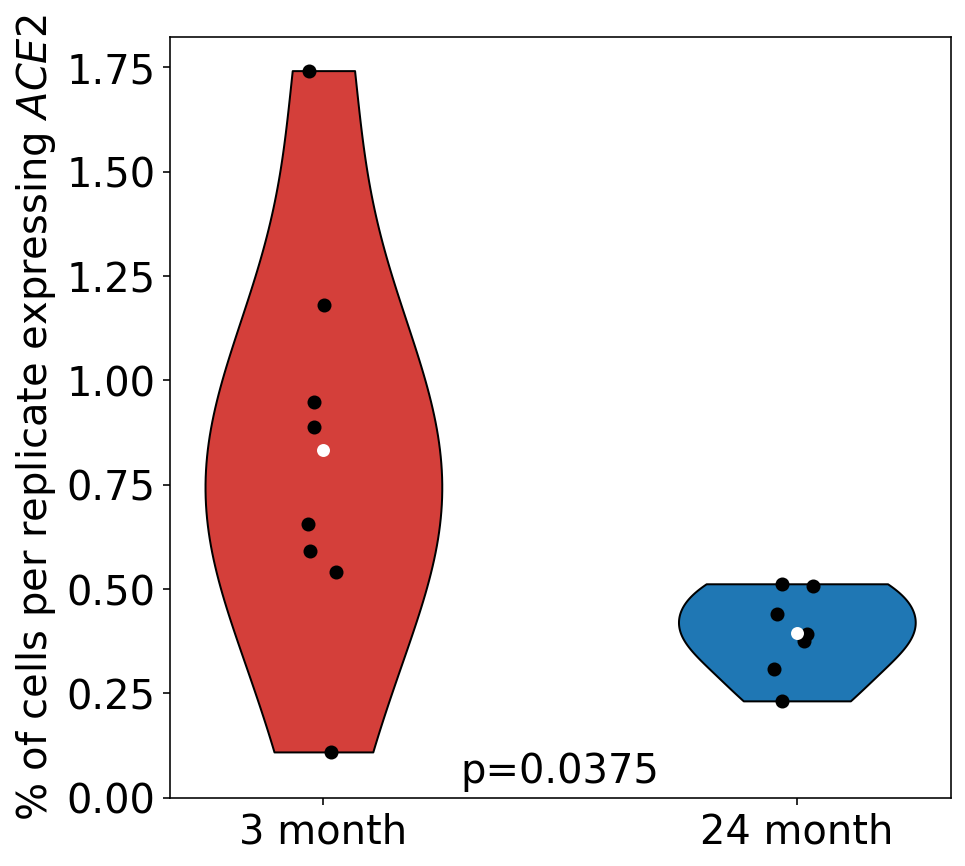

In [21]:
fig, ax = plt.subplots(figsize=(7,7))

labels = ['3 month', "24 month"]
lidx = [1, 2]


x = [young, old]

parts = ax.violinplot(x, showmedians=False, showextrema=False)
for pcidx, pc in enumerate(parts['bodies']):
    pc.set_facecolor('#D43F3A')
    if pcidx==1: pc.set_facecolor('#1f77b4')
    pc.set_edgecolor('black')
    pc.set_alpha(1)

    
mean = [np.mean(i) for i in x]
ax.scatter(lidx, mean, marker='o', color='white', s=30, zorder=3)

######## Add some random "jitter" to the x-axis
x = np.random.normal(1, 0.04, size=len(young))
ax.scatter(x, young, alpha=1, color="k")

x = np.random.normal(2, 0.04, size=len(old))
ax.scatter(x, old, alpha=1, color="k")

ax.set_xticks(lidx)
ax.set_xticklabels(labels)

ax.set_ylabel("% of cells per replicate expressing $ACE2$")
ax.annotate("p={:,.4f}".format(p), (1.5, ax.get_ylim()[1]*0.02), ha="center")
ax.set_ylim(0)
plt.savefig("./figs/old_young_ACE2_PRESENCE.png", bbox_inches='tight',dpi=300)


plt.show()

In [22]:
print(np.mean(young))
print(np.mean(old))

0.8320250216449071
0.39518169365750877


In [75]:
0.8320250216449071/0.39518169365750877

2.105423998627822

In [23]:
p

0.03753637129440112

______________

# TMPRSS2 clean

In [24]:
gene = "Tmprss2"

In [25]:
mask = nd(data.layers["raw"].todense()[:,data.var.index.values==gene])>0
print("There {} cells with non-zero expression of {}.".format(mask.sum(), gene))

There 282 cells with non-zero expression of Tmprss2.


In [26]:
young_mask = data.obs.age==3
old_mask = data.obs.age==24

In [27]:
print("There {} 3 month lung cells with non-zero expression of {}.".format(np.logical_and(mask, young_mask).sum(), gene))
print("There {} 24 month lung cells with non-zero expression of {}.".format(np.logical_and(mask, old_mask).sum(), gene))

There 171 3 month lung cells with non-zero expression of Tmprss2.
There 111 24 month lung cells with non-zero expression of Tmprss2.


## Per condition and per replicate

In [28]:
assignments = data.obs.leiden.values.astype(int)
unique = np.unique(assignments)
mtx = data.layers["raw"]

In [29]:
gene_idx = np.where(data.var.index.values==gene)[0][0]
arr = nd(mtx[:,gene_idx].todense())

df = data.obs.copy()

df["TMPRSS2"] = arr

In [30]:
print((arr>0).sum())
print(data.var.index.values[gene_idx])

282
Tmprss2


In [31]:
df.head()

,SRR,age,cell_counts,n_genes,percent_mito,pass_count_filter,pass_mito_filter,leiden,louvain,TMPRSS2
AAAAAAAAAAAA-SRR8426368,SRR8426368,3,11.0,11,0.000000,True,True,12,13,0.0
AAAACCGGAGGC-SRR8426368,SRR8426368,3,301.0,238,1.993356,True,True,10,11,0.0
AAAACGCACGTC-SRR8426368,SRR8426368,3,274.0,209,1.824817,True,True,3,2,0.0
AAAAGACCAAAT-SRR8426368,SRR8426368,3,648.0,339,3.549383,True,True,0,0,0.0
AAAAGGAGCAGA-SRR8426368,SRR8426368,3,471.0,312,1.273885,True,True,2,5,0.0


# Expression of TMPRSS2

In [32]:
young = df[df["age"] == 3]["TMPRSS2"].values.tolist()
old = df[df["age"] == 24]["TMPRSS2"].values.tolist()
stat, p = stats.ttest_ind(young, old)
#stat, p = stats.ks_2samp(young, old)

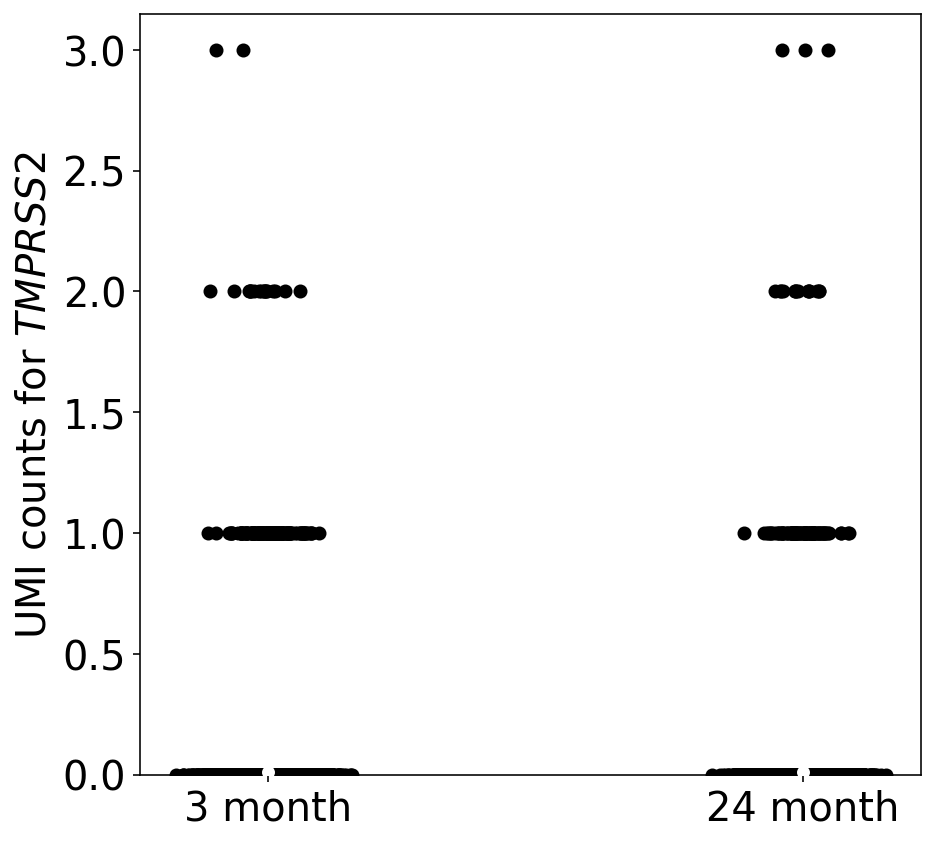

In [33]:
fig, ax = plt.subplots(figsize=(7,7))

gene = "TMPRSS2"

labels = ['3 month', "24 month"]
lidx = [1, 2]


x = [young, old]

#parts = ax.violinplot(x, showmedians=False, showextrema=False)
#for pcidx, pc in enumerate(parts['bodies']):
#    pc.set_facecolor('#D43F3A')
#    if pcidx==1: pc.set_facecolor('#1f77b4')
#    pc.set_edgecolor('black')
#    pc.set_alpha(1)

    
mean = [np.mean(i) for i in x]
ax.scatter(lidx, mean, marker='o', color='white', s=30, zorder=3)


######## Add some random "jitter" to the x-axis
x = np.random.normal(1, 0.04, size=len(young))
ax.scatter(x, young, alpha=1, color="k")

x = np.random.normal(2, 0.04, size=len(old))
ax.scatter(x, old, alpha=1, color="k")

##########
ax.set_xticks(lidx)
ax.set_xticklabels(labels)



#ax.annotate("p={:,.3f}".format(p), (1.5, ax.get_ylim()[1]*0.02), ha="center")

ax.set_ylim(0)

ax.set_ylabel("UMI counts for $TMPRSS2$")
#plt.savefig("./figs/old_young_ACE2_EXPRESSION.png", bbox_inches='tight',dpi=300)

plt.show()

In [34]:
print(np.mean(young))
print(np.mean(old))

0.01171969880981297
0.010415838435238928


In [35]:
p

0.3566490483879945

# Fraction of cells expressing TMPRSS2

In [36]:
tmprss2 = df.groupby(["SRR"])["TMPRSS2"].apply(lambda x: (x>0).sum())
tmprss2 = tmprss2.reset_index()
tmprss2 = tmprss2.rename(columns={"TMPRSS2":"nnz"})

In [37]:
tmprss2.head()

,SRR,nnz
0,SRR8426368,32
1,SRR8426359,11
2,SRR8426362,36
3,SRR8426364,12
4,SRR8426369,12


In [38]:
tmprss2["size"] = df.groupby(["SRR"])["TMPRSS2"].apply(lambda x: len(x)).reset_index()["TMPRSS2"]
tmprss2["frac"] = tmprss2["nnz"]/tmprss2["size"].astype(float)*100
tmprss2["age"] = tmprss2.SRR.map(age_map)

In [39]:
tmprss2.head()

,SRR,nnz,size,frac,age
0,SRR8426368,32,2709,1.181248,3
1,SRR8426359,11,1366,0.805271,24
2,SRR8426362,36,2569,1.401323,24
3,SRR8426364,12,1134,1.058201,24
4,SRR8426369,12,1276,0.940439,24


In [40]:
young = (tmprss2[tmprss2["age"] == 3]["frac"].values).tolist()
old   = (tmprss2[tmprss2["age"] == 24]["frac"].values).tolist()
stat, p = stats.ttest_ind(young, old)
#stat, p = stats.ks_2samp(young, old)

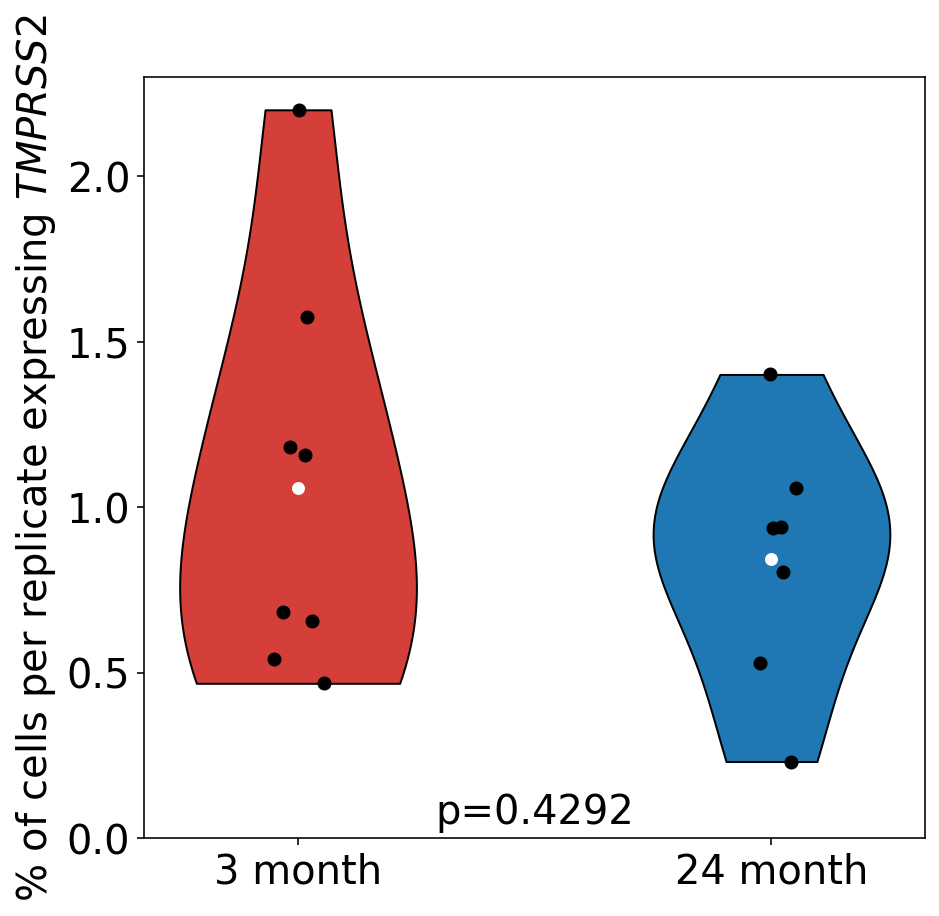

In [41]:
fig, ax = plt.subplots(figsize=(7,7))

labels = ['3 month', "24 month"]
lidx = [1, 2]


x = [young, old]

parts = ax.violinplot(x, showmedians=False, showextrema=False)
for pcidx, pc in enumerate(parts['bodies']):
    pc.set_facecolor('#D43F3A')
    if pcidx==1: pc.set_facecolor('#1f77b4')
    pc.set_edgecolor('black')
    pc.set_alpha(1)

    
mean = [np.mean(i) for i in x]
ax.scatter(lidx, mean, marker='o', color='white', s=30, zorder=3)

######## Add some random "jitter" to the x-axis
x = np.random.normal(1, 0.04, size=len(young))
ax.scatter(x, young, alpha=1, color="k")

x = np.random.normal(2, 0.04, size=len(old))
ax.scatter(x, old, alpha=1, color="k")

ax.set_xticks(lidx)
ax.set_xticklabels(labels)

ax.set_ylabel("% of cells per replicate expressing $TMPRSS2$")
ax.annotate("p={:,.4f}".format(p), (1.5, ax.get_ylim()[1]*0.02), ha="center")
ax.set_ylim(0)
#plt.savefig("./figs/old_young_TMPRSS2_PRESENCE.png", bbox_inches='tight',dpi=300)


plt.show()

In [42]:
print(np.mean(young))
print(np.mean(old))

1.058086974243913
0.8432654194491894


In [43]:
p

0.4292108966506827

# Where is ACE2 and TMPRSS2 expressed?

In [44]:
ace2 = nd(data.layers["log1p"].todense()[:,data.var.index.values=="Ace2"])

In [45]:
mask = ace2>0
c_ace = data.obs["leiden"][mask].value_counts().sort_index()

In [46]:
tmprss2 = nd(data.layers["log1p"].todense()[:,data.var.index.values=="Tmprss2"])

In [47]:
mask = tmprss2>0
c_tmprss = data.obs["leiden"][mask].value_counts().sort_index()

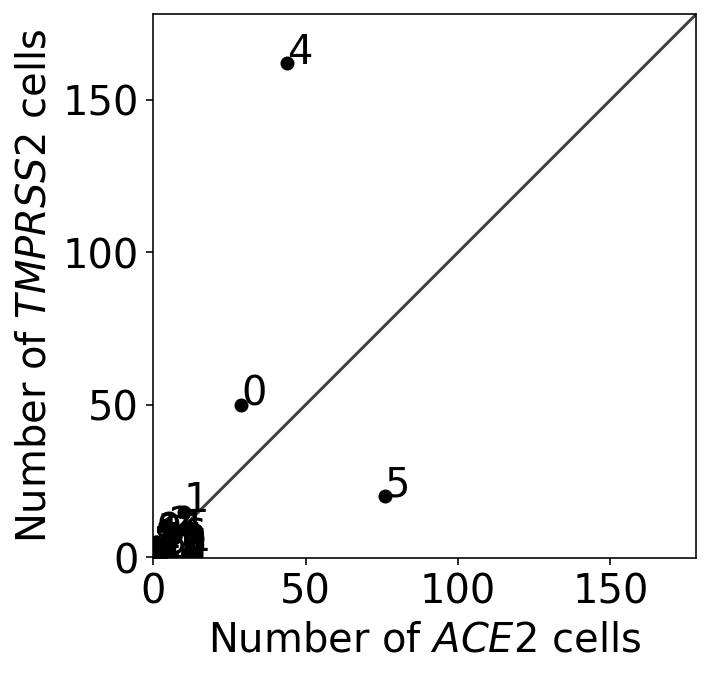

In [48]:
fig, ax = plt.subplots(figsize=(5,5))

idx = c_ace.index.values

x = c_ace.values
y = c_tmprss.values

ax.scatter(x, y, color="k")



for tn, t in enumerate(idx):
    ax.annotate(t, (x[tn], y[tn]))

mx = max(c_ace.max(), c_tmprss.max())

ax.set_xlim(-0.1, mx*(1+0.1))
ax.set_ylim(-0.1, mx*(1+0.1))

ax.set_xlabel("Number of $ACE2$ cells")
ax.set_ylabel("Number of $TMPRSS2$ cells")



yex(ax)

plt.savefig("./figs/ACE2_TMPRSS2_cluster_comparison.png", bbox_inches='tight',dpi=300)


plt.show()

# In which clusters are the ACE2 AND TMPRSS2 cells in?

In [49]:
data.obs.leiden[np.logical_and(ace2>0, tmprss2)].value_counts()

4     8
5     4
23    0
22    0
1     0
2     0
3     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
0     0
Name: leiden, dtype: int64

# In-silico bulk comparison ACE2

In [50]:
ace2 = nd(data.layers["norm"][:,data.var.index.values=="Ace2"].todense())

In [51]:
young_mask = data.obs.age==3
old_mask = data.obs.age==24

young = ace2[young_mask]
old = ace2[old_mask]

In [52]:
print("3 month:  {:,.4f} TPM".format(young.mean()))
print("24 month: {:,.4f} TPM".format(old.mean()))

3 month:  8.1267 TPM
24 month: 4.9792 TPM


# In-silico bulk comparison TMPRSS2

In [53]:
tmprss2 = nd(data.layers["norm"][:,data.var.index.values=="Tmprss2"].todense())

In [54]:
young_mask = data.obs.age==3
old_mask = data.obs.age==24

young = tmprss2[young_mask]
old = tmprss2[old_mask]

In [55]:
print("3 month:  {:,.4f} TPM".format(young.mean()))
print("24 month: {:,.4f} TPM".format(old.mean()))

3 month:  14.7881 TPM
24 month: 11.2682 TPM


# How many cells express both Tmprss2 and ACE2 in old vs young?

In [56]:
ace2 = nd(data.layers["norm"][:,data.var.index.values=="Ace2"].todense())

In [57]:
young_mask = data.obs.age==3
old_mask = data.obs.age==24

ace2_young = ace2[young_mask]
ace2_old = ace2[old_mask]

In [58]:
tmprss2 = nd(data.layers["norm"][:,data.var.index.values=="Tmprss2"].todense())

In [59]:
young_mask = data.obs.age==3
old_mask = data.obs.age==24

tmprss2_young = tmprss2[young_mask]
tmprss2_old = tmprss2[old_mask]

In [60]:
print("{} cells in 3 month lungs express both ACE2 and TMPRSS2.".format(np.logical_and(ace2_young, tmprss2_young).sum()))
print("{} cells in 24 month lungs express both ACE2 and TMPRSS2.".format(np.logical_and(ace2_old, tmprss2_old).sum()))

7 cells in 3 month lungs express both ACE2 and TMPRSS2.
5 cells in 24 month lungs express both ACE2 and TMPRSS2.


# Venn diagram # of cells in old v young


| Gene         | 3 month  | 24 month   | Total  |
| ------------ |:------:| ----:|---------|
| Ace2         | 130    | 50   | 180 |
| Tmprss2      | 171    |  111 | 282 |
| Total        | 301    | 161  | 462 |

In [61]:
n_young = (data.obs.age==3).sum()
n_old = (data.obs.age==24).sum()

In [62]:
print("N young = {:,}".format(n_young))
print("N old   = {:,}".format(n_old))

N young = 16,468
N old   = 12,577


In [63]:
from matplotlib_venn import venn2, venn2_circles

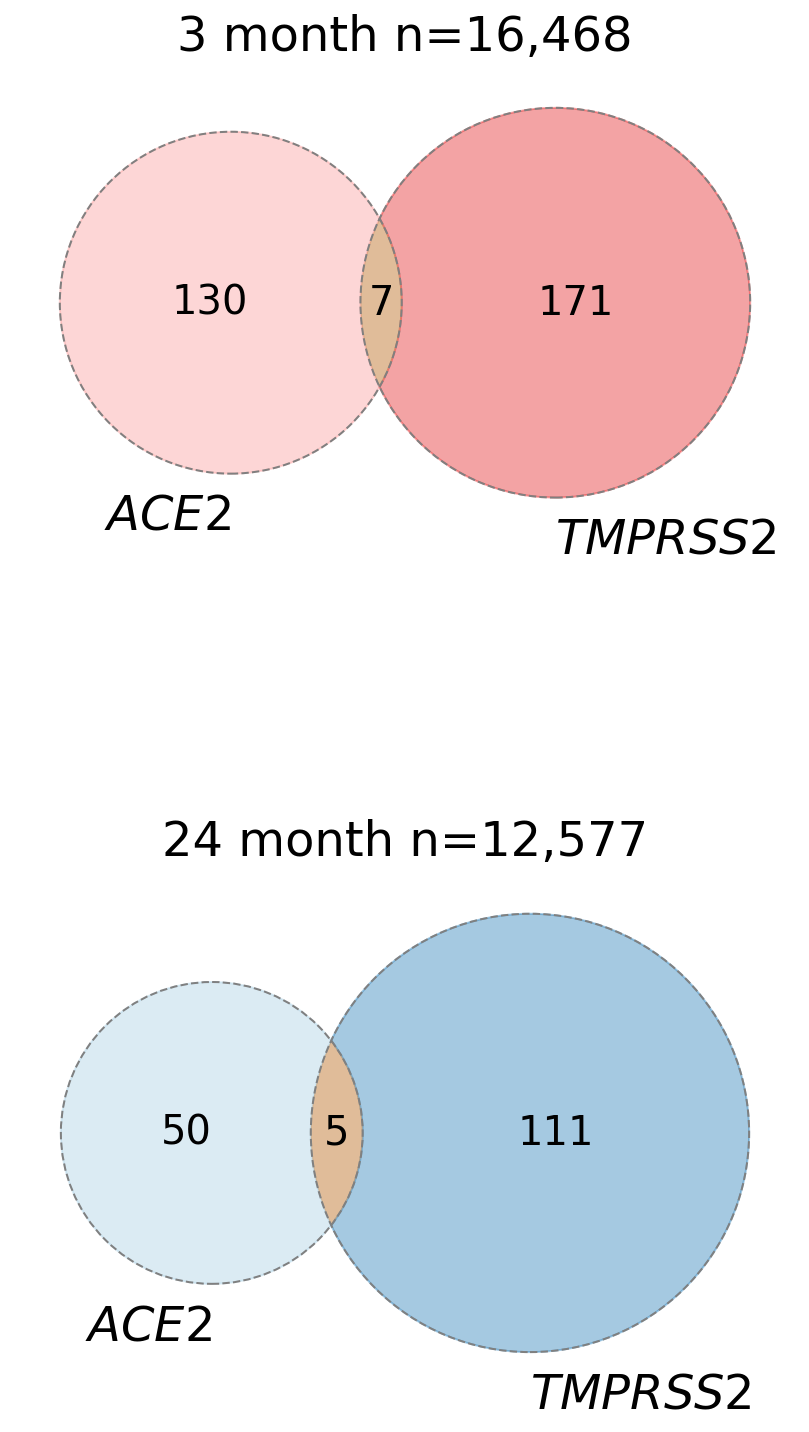

In [64]:
# Young
fig, ax = plt.subplots(figsize=(7, 14), nrows=2)
# (ACE2, TMPRSS, both)


A = 130
B = 171
C = 7

subset = (A, B, C)
v = venn2(subsets=subset, ax=ax[0], set_labels=("$ACE2$", "$TMPRSS2$"))
c = venn2_circles(subsets=subset, linestyle='dashed', linewidth=1, color="grey", ax=ax[0])
ax[0].set_title("3 month n={:,}".format(n_young))

v.get_patch_by_id('10').set_color((0.98431372549019602, 0.60392156862745094, 0.6                ))
v.get_patch_by_id('01').set_color(    (0.8901960784313725,  0.10196078431372549, 0.10980392156862745))


A = 50
B = 111
C = 5

subset = (A,B,C)
v = venn2(subsets=subset, ax=ax[1], set_labels=("$ACE2$", "$TMPRSS2$"))
c = venn2_circles(subsets=subset, linestyle='dashed', linewidth=1, color="grey", ax=ax[1])
ax[1].set_title("24 month n={:,}".format(n_old))

v.get_patch_by_id('10').set_color((0.65098039215686276, 0.80784313725490198, 0.8901960784313725 ))
v.get_patch_by_id('01').set_color((0.12156862745098039, 0.47058823529411764, 0.70588235294117652))

plt.savefig("./figs/old_young_same_cells.png", bbox_inches='tight',dpi=300)

plt.show()